<center><h1><b>Sismic map based on the Gutember-Richter law and hierarchical clustering </b></h1></center>

In [59]:
library(ggplot2)
library(dplyr)
library(stats)
library(sf)
library(geosphere)
library(patchwork)
library(reshape2)
library(cluster)

---

## LOADING AND CLEANING DATA DATA
We took the data from https://earthquake.usgs.gov/ in two parts because there was a limit in the download size.

In [60]:
df1 = read.table("./data/earthquakes_years_2000_2025.csv", header=TRUE, sep=',')
df2 = read.table("./data/earthquakes_years_1925_2000.csv", header=TRUE, sep=',')
cat("The 1st database has ", nrow(df1), " rows", "\n")
cat("The 2nd database has ", nrow(df2), " rows", "\n")
df = rbind(df1, df2)
cat("The final database has ", nrow(df), " rows", "\n")

The 1st database has  13988  rows 
The 2nd database has  14850  rows 
The final database has  28838  rows 


In [61]:
# Convert the time column to Date format
df$time <- as.POSIXct(df$time, format = "%Y-%m-%dT%H:%M:%OSZ", tz = "UTC")

In [62]:
summary(df)

      time                            latitude       longitude    
 Min.   :1925-02-07 12:14:58.150   Min.   :35.61   Min.   : 4.66  
 1st Qu.:1990-07-11 12:17:33.473   1st Qu.:39.37   1st Qu.:10.98  
 Median :1999-06-07 03:23:02.495   Median :42.74   Median :15.27  
 Mean   :1997-09-22 00:29:15.603   Mean   :42.17   Mean   :14.92  
 3rd Qu.:2004-10-01 01:05:55.349   3rd Qu.:44.44   3rd Qu.:20.01  
 Max.   :2025-06-24 03:04:54.730   Max.   :47.76   Max.   :20.87  
                                                                  
     depth             mag          magType               nst        
 Min.   : -2.00   Min.   :2.500   Length:28838       Min.   :  0.00  
 1st Qu.:  8.60   1st Qu.:2.700   Class :character   1st Qu.:  7.00  
 Median : 10.00   Median :3.100   Mode  :character   Median : 14.00  
 Mean   : 15.02   Mean   :3.284                      Mean   : 30.35  
 3rd Qu.: 10.00   3rd Qu.:3.600                      3rd Qu.: 35.00  
 Max.   :522.00   Max.   :7.000             

In [63]:
head(df,10)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,⋯,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
1,2025-06-24 03:04:54,41.4136,19.5656,10.000,4.2,mb,41,56,0.233,0.98,⋯,2025-06-24T08:13:22.962Z,"7 km N of Shijak, Albania",earthquake,4.47,1.932,0.110,23,reviewed,us,us
2,2025-06-21 14:56:54,38.0214,20.2244,53.184,4.2,mb,20,124,1.591,0.98,⋯,2025-06-21T15:51:45.040Z,"27 km SW of Lixoúri, Greece",earthquake,2.82,12.614,0.200,9,reviewed,us,us
3,2025-06-21 13:25:52,37.9115,20.1867,10.000,4.5,mb,41,107,1.563,1.14,⋯,2025-06-22T11:05:17.735Z,"38 km SW of Lixoúri, Greece",earthquake,6.06,1.895,0.079,47,reviewed,us,us
4,2025-06-01 16:44:09,43.1747,17.9562,10.000,4.0,mb,49,31,1.215,0.68,⋯,2025-06-22T16:37:44.040Z,"8 km ENE of Crnići, Bosnia and Herzegovina",earthquake,5.05,1.931,0.150,12,reviewed,us,us
5,2025-05-22 22:52:00,42.5041,18.3603,10.000,4.0,mb,33,42,0.670,0.82,⋯,2025-06-08T22:23:48.661Z,"12 km WNW of Igalo, Montenegro",earthquake,2.14,1.927,0.123,18,reviewed,us,us
6,2025-05-20 22:37:03,45.9604,11.1350,11.615,2.7,ml,25,79,0.369,0.60,⋯,2025-05-21T13:40:42.272Z,"2 km NE of Besenello, Italy",earthquake,2.28,5.934,0.057,40,reviewed,us,us
7,2025-05-13 10:07:45,40.8277,14.0646,10.000,4.0,mwr,65,105,0.432,0.45,⋯,2025-06-05T13:58:19.046Z,"3 km SW of Pozzuoli, Italy",earthquake,5.26,1.909,0.093,11,reviewed,us,us
8,2025-05-11 11:46:53,42.9684,18.6709,10.000,4.4,mb,47,37,0.692,0.79,⋯,2025-06-13T05:29:08.040Z,"22 km ENE of Bileća, Bosnia and Herzegovina",earthquake,4.11,1.932,0.130,17,reviewed,us,us
9,2025-05-10 04:51:34,38.0915,20.3410,42.571,4.1,mb,36,119,1.553,0.99,⋯,2025-05-26T22:31:13.040Z,"14 km SW of Lixoúri, Greece",earthquake,6.39,10.659,0.140,14,reviewed,us,us


### CLEANING

Not a very good dataset, there are many NA values. In particular many columns are almost useless for this (magError, depthError...).

Let's keep only useful columns:

In [64]:
df_cleaned <- df[, c('time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'id','place', 'locationSource', 'status') ]

In [65]:
# check for NA values in selected columns:
for (col in 1:length(df_cleaned) ) {
    cat("Number of NA values in column ", col, ": ", sum(is.na(df_cleaned[1])), "\n")
}

Number of NA values in column  1 :  0 
Number of NA values in column  2 :  0 
Number of NA values in column  3 :  0 
Number of NA values in column  4 :  0 
Number of NA values in column  5 :  0 
Number of NA values in column  6 :  0 
Number of NA values in column  7 :  0 
Number of NA values in column  8 :  0 
Number of NA values in column  9 :  0 
Number of NA values in column  10 :  0 


In [66]:
df_cleaned <- df_cleaned %>% filter(grepl("Italy$", place))

head(df_cleaned)

,time,latitude,longitude,depth,mag,magType,id,place,locationSource,status
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,2025-05-20 22:37:03,45.9604,11.1350,11.615,2.7,ml,us7000q0g6,"2 km NE of Besenello, Italy",us,reviewed
2,2025-05-13 10:07:45,40.8277,14.0646,10.000,4.0,mwr,us7000pyym,"3 km SW of Pozzuoli, Italy",us,reviewed
3,2025-05-08 01:42:59,41.8207,12.7418,9.538,2.7,ml,us7000pxxr,"1 km NNE of Montecompatri, Italy",us,reviewed
4,2025-04-16 01:26:09,37.6250,16.1162,51.185,4.7,mb,us6000q6cn,"34 km SSE of Palizzi Marina, Italy",us,reviewed
5,2025-03-18 09:01:26,40.6596,15.8360,17.181,4.3,mwr,us6000pzjc,"3 km NE of Potenza, Italy",us,reviewed
6,2025-03-15 20:45:58,38.0732,12.2019,10.000,4.0,mb,us6000pz2t,"19 km NW of Favignana, Italy",us,reviewed


---

## Sismic map based on the Gutember-Richter law

In order to obtain a sismic map based on the Gutemberg-Richter law we will follow these steps:
- Divide the Region into grid Cells
- Apply the Gutenberg-Richter Formula
  - Count the number of events above different magnitudes
  - Fit the G-R law using linear regression on $log_{10}(N)$ vs. $M$
  - Derive local $a$ and $b$ values
- Create heat maps:
  - One showing seismicity rate (the $a$ value)
  - One showing the relative hazard (via the b value. Lower $b$ means more large earthquakes)


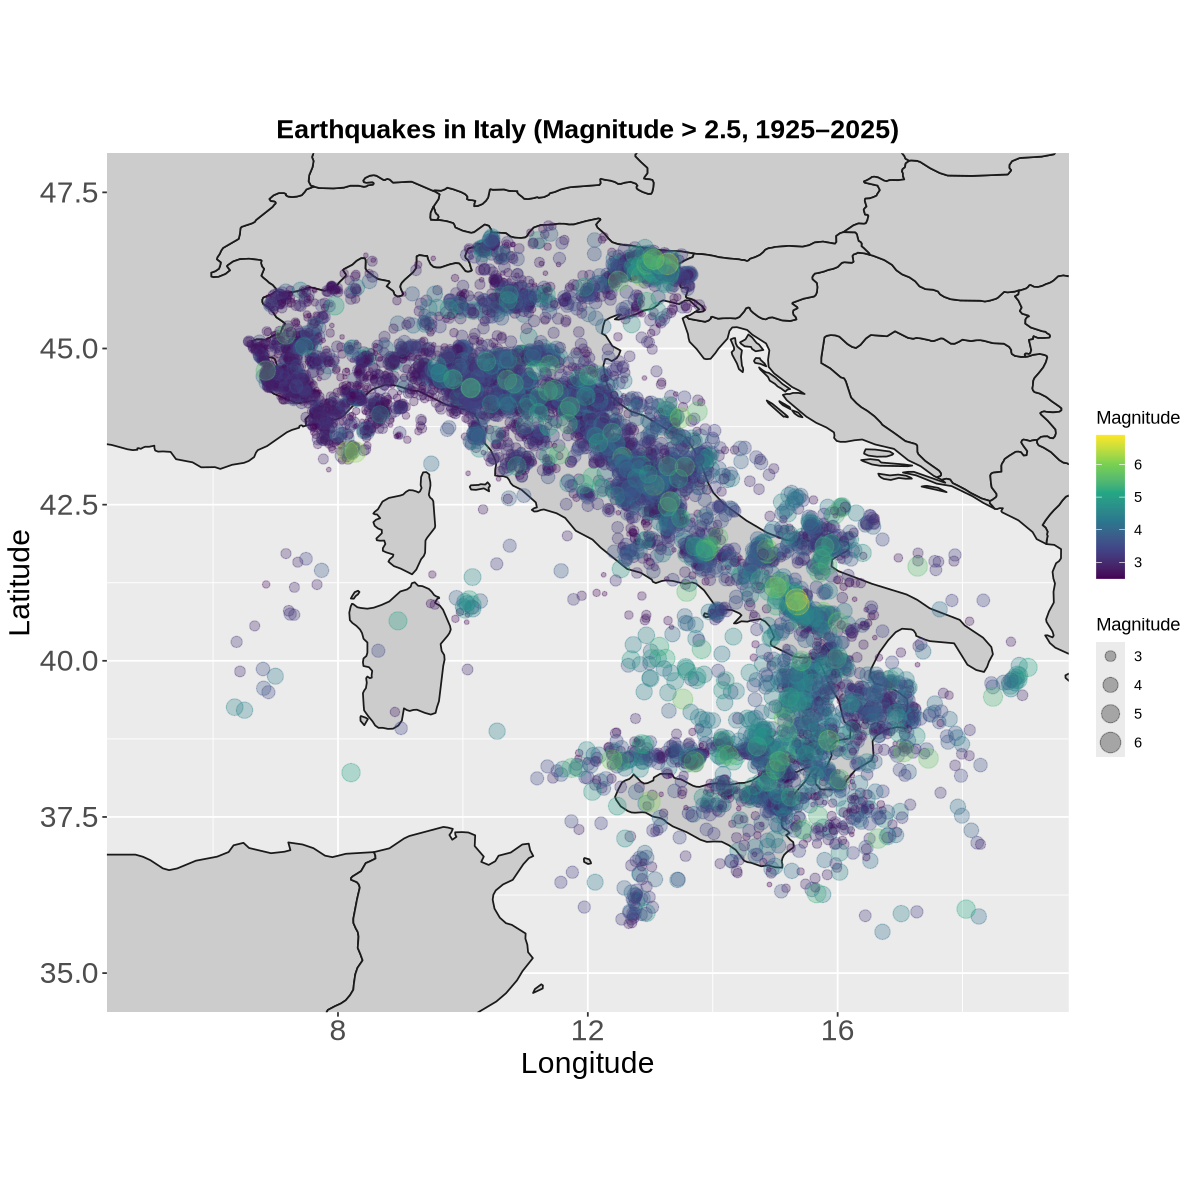

In [67]:
# Start simply visualizing the data

# image print out options
options(repr.plot.width=10, repr.plot.height=10)

# theme
proj_theme <- function() {
  theme(
    plot.title = element_text(
      face = "bold", # style: "plain", "italic", "bold"
      size = 16,
      color = "black",
      hjust = 0.5 # horizontal position (0 = left, 1 = right, 0.5 = center)
    ),
    axis.text.x = element_text(size = 18),
    axis.text.y = element_text(size = 18),
    axis.title.x = element_text(size = 18),
    axis.title.y = element_text(size = 18)
  )
}

# regions to plot in the map
reg <- c("Italy", "Germany", "Switzerland", "France", "Austria", "Slovenia", "Croatia", 
        "Greece", "Albania", "Bosnia and Herzegovina", "Hungary", "Slovakia", "Liechtenstein", "Montenegro", 
        "Serbia", "Kosovo", "Romania", "North Macedonia", "Tunisia", "Algeria")

all_earthquakes <- ggplot(df_cleaned, aes(x = longitude, y = latitude)) +
  # let's draw the map outline of Italy using the "maps" package
  borders("world", 
          regions = reg, fill = "gray80", colour = "gray10") +
  geom_point(aes(size = mag, color = mag), alpha = 0.3) +
  coord_fixed(xlim = c(5, 19), ylim = c(35, 47.5)) +    #  ensures the aspect ratio is preserved, so the map doesn’t look stretched
  scale_color_viridis_c() +
  labs(title = "Earthquakes in Italy (Magnitude > 2.5, 1925–2025)",
       x = "Longitude", 
       y = "Latitude", 
       color = "Magnitude", 
       size = "Magnitude") +
  proj_theme()

#ggsave("all_earthquakes.png", plot = all_earthquakes, width = 8, height = 6, dpi = 300)
all_earthquakes

In [68]:
# set the values for the grid
lat_grid <- seq(min(df_cleaned$latitude), max(df_cleaned$latitude), 0.25)
lon_grid <- seq(min(df_cleaned$longitude), max(df_cleaned$longitude), 0.25)
mag_values <- seq(4,7,0.1)  # groups of magnitudes => levels of the array to hold the data

# N is a matrix that cointains the number of earthquakes cell by cell
j <- 1:(length(lat_grid)-1)
k <- 1:(length(lon_grid)-1)
i <- 1:(length(mag_values)-1)
N <- array(0, dim = c(length(j), length(k), length(i)))
        
for (lat_i in j){
    for (lon_i in k){
        for (mag_i in i){
        N[lat_i, lon_i, mag_i] <- nrow(df_cleaned[df_cleaned$latitude < lat_grid[lat_i+1] & 
                df_cleaned$latitude >= lat_grid[lat_i] & 
                df_cleaned$longitude < lon_grid[lon_i+1] & 
                df_cleaned$longitude >= lon_grid[lon_i] & 
                df_cleaned$mag >= mag_values[mag_i] , ])
        }
    }
}


In [69]:
# Check the array dimension
cat("The array dimension are: ", dim(N))

The array dimension are:  45 50 30

In [70]:
# perform the fit cell by cell

# create empty matrices
b_values <- matrix(NA, nrow = length(j), ncol = length(k))
a_values <- matrix(NA, nrow = length(j), ncol = length(k))

for (lat_i in j){
  for (lon_i in k){
    counts <- N[lat_i, lon_i, ]
    mags <- mag_values[-length(mag_values)]  # since N uses intervals
    if (sum(counts != 0) >= 7 ) {  # ensure enough data 
      log_N <- log10(counts)
      log_N[!is.finite(log_N)] <- NA  # convert -Inf to NA
      fit <- lm(log_N ~ mags)
      # save the fit coefficients
      b_values[lat_i, lon_i] <- -coef(fit)[2] 
      a_values[lat_i, lon_i] <- coef(fit)[1]
    }
  }
}

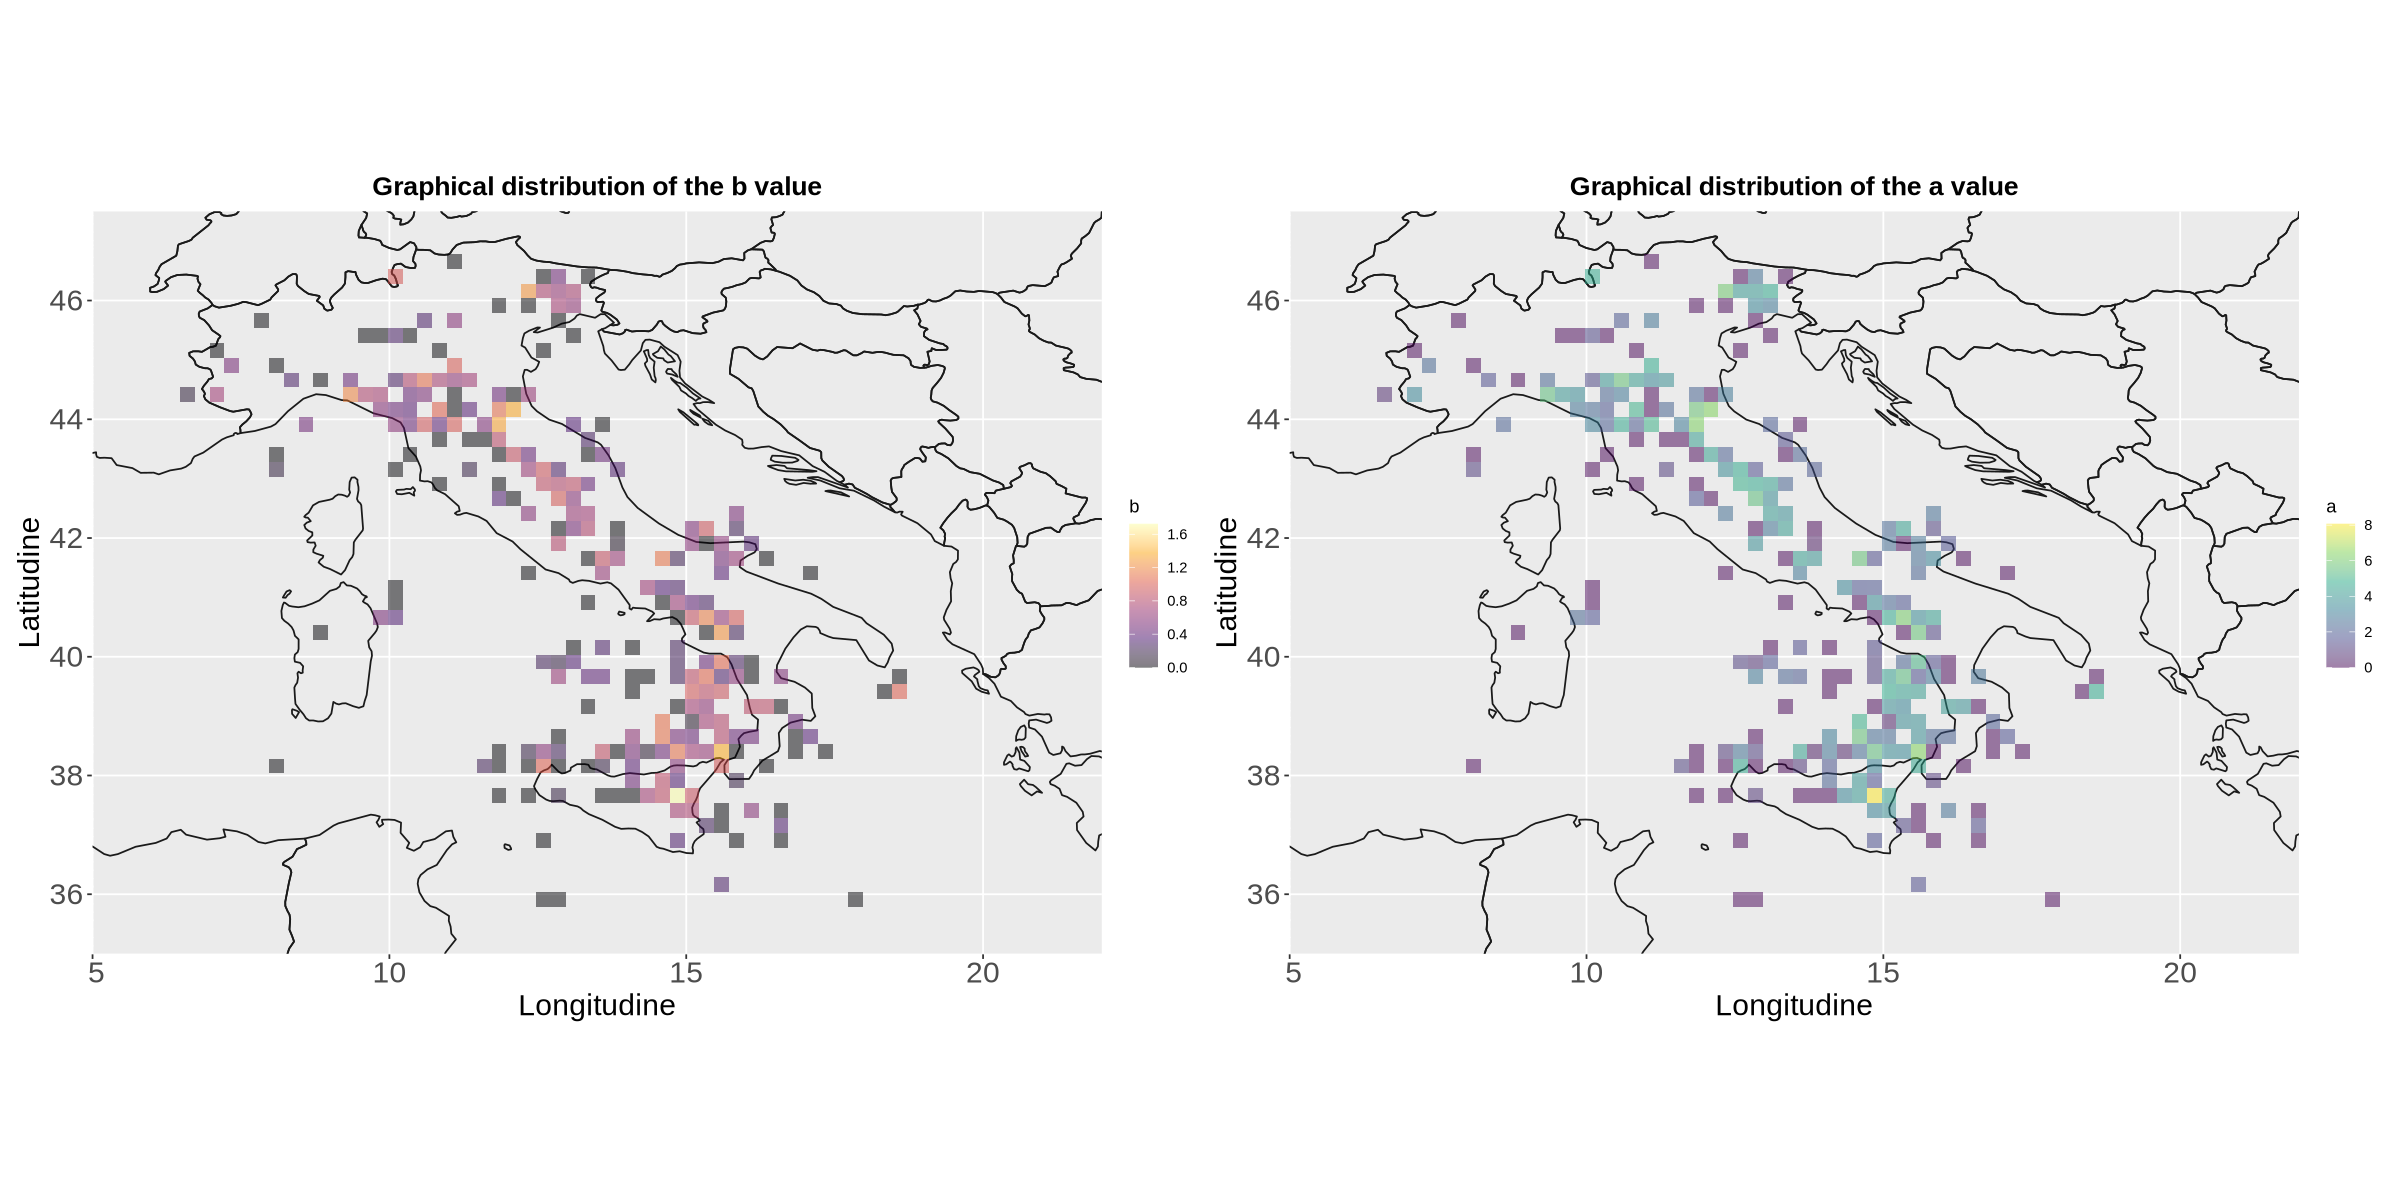

In [71]:

# prepare the data in a dataframe
b_df <- melt(b_values)
a_df <- melt(a_values)
colnames(b_df) <- c("lat_index", "lon_index", "b_value")
colnames(a_df) <- c("lat_index", "lon_index", "a_value")

b_df$lat <- lat_grid[b_df$lat_index]
b_df$lon <- lon_grid[b_df$lon_index]
a_df$lat <- lat_grid[a_df$lat_index]
a_df$lon <- lon_grid[a_df$lon_index]


# plot the a and b values in a grid 

b_plot <- ggplot() +
  # borders
  borders("world", 
          regions = c(reg), 
          fill = "gray80", colour = "gray10", alpha = 0) +

  # placche tettoniche
  #geom_sf(data = placche, color = "blue", size = 2) +

  # heatmap for the b parameter
  geom_tile(data = b_df, aes(x = lon, y = lat, fill = b_value), color = NA, na.rm = TRUE) +
  coord_sf(xlim = c(5, 22), ylim = c(35, 47.5), expand = FALSE) +
  scale_fill_viridis_c(option = "inferno", na.value = "transparent", alpha = 0.5) +
  labs(title = "Graphical distribution of the b value", x = "Longitudine", y = "Latitudine", fill = "b") +
  proj_theme()

#----------------------------------------------------------------------------------------------------------

a_plot  <- ggplot() +
  # borders
  borders("world", 
          regions = c(reg), 
          fill = "gray80", colour = "gray10", alpha = 0) +

  # placche tettoniche
  #geom_sf(data = placche, color = "blue", size = 2) +

  # heatmap parametro b
  geom_tile(data = a_df, aes(x = lon, y = lat, fill = a_value), color = NA, na.rm = TRUE) +
  coord_sf(xlim = c(5, 22), ylim = c(35, 47.5), expand = FALSE) +
  scale_fill_viridis_c(option = "viridis", na.value = "transparent", alpha = 0.5) +
  labs(title = "Graphical distribution of the a value", x = "Longitudine", y = "Latitudine", fill = "a") +
  proj_theme()




options(repr.plot.width = 20, repr.plot.height = 10)
b_plot + a_plot

#ggsave("G_R_parameters.png", plot = b_plot + a_plot, width = 20, height = 10, dpi = 300)


- **b-value map**: It highlights areas where seismicity is dominated by small earthquakes ($b > 1$) or by strong events ($b < 1$). High values are typical of swarms.
- **a-value map**: It shows the absolute level of seismic activity. Areas with high values have many earthquakes, regardless of magnitude.



In [72]:
# https://www.usgs.gov/programs/earthquake-hazards/google-earthtmkml-files -> page where you can find the file for the edge of the plates
# Instructions: 1) Rename the file to .zip; 2) Extract the file; 3) Get the .kml file;
layers_info <- st_layers("doc.kml")
print(layers_info)

Driver: LIBKML 
Available layers:
                          layer_name geometry_type features fields crs_name
1                   Plate Boundaries                      0     13   WGS 84
2                    Plate Interface                   1175     13   WGS 84
3 Micro Plates and Major Fault Zones                    221     13   WGS 84
4                       Plate Motion                    191     12   WGS 84


In [73]:
plates <- st_read("doc.kml", layer = "Plate Interface")

Reading layer `Plate Interface' from data source 
  `/home/pira/Documenti/PoD/AdvancedStatistics/Earthquakes_Analysis_Italy/doc.kml' 
  using driver `LIBKML'
Simple feature collection with 1175 features and 13 fields
Geometry type: MULTILINESTRING
Dimension:     XYZ
Bounding box:  xmin: -180 ymin: -66.163 xmax: 180 ymax: 86.805
z_range:       zmin: 0 zmax: 0
Geodetic CRS:  WGS 84


Simple feature collection with 1175 features and 13 fields
Geometry type: MULTILINESTRING
Dimension:     XYZ
Bounding box:  xmin: -180 ymin: -66.163 xmax: 180 ymax: 86.805
z_range:       zmin: 0 zmax: 0
Geodetic CRS:  WGS 84
First 10 features:
         id                    Name
1  ID_00000 Eurasian:North American
2  ID_00001 Eurasian:North American
3  ID_00002 Eurasian:North American
4  ID_00003 Eurasian:North American
5  ID_00004 Eurasian:North American
6  ID_00005 Eurasian:North American
7  ID_00006 Eurasian:North American
8  ID_00007 Eurasian:North American
9  ID_00008 Eurasian:North American
10 ID_00009 Eurasian:North American
                                                                                                                                                                                                                                                                                                                                                                        

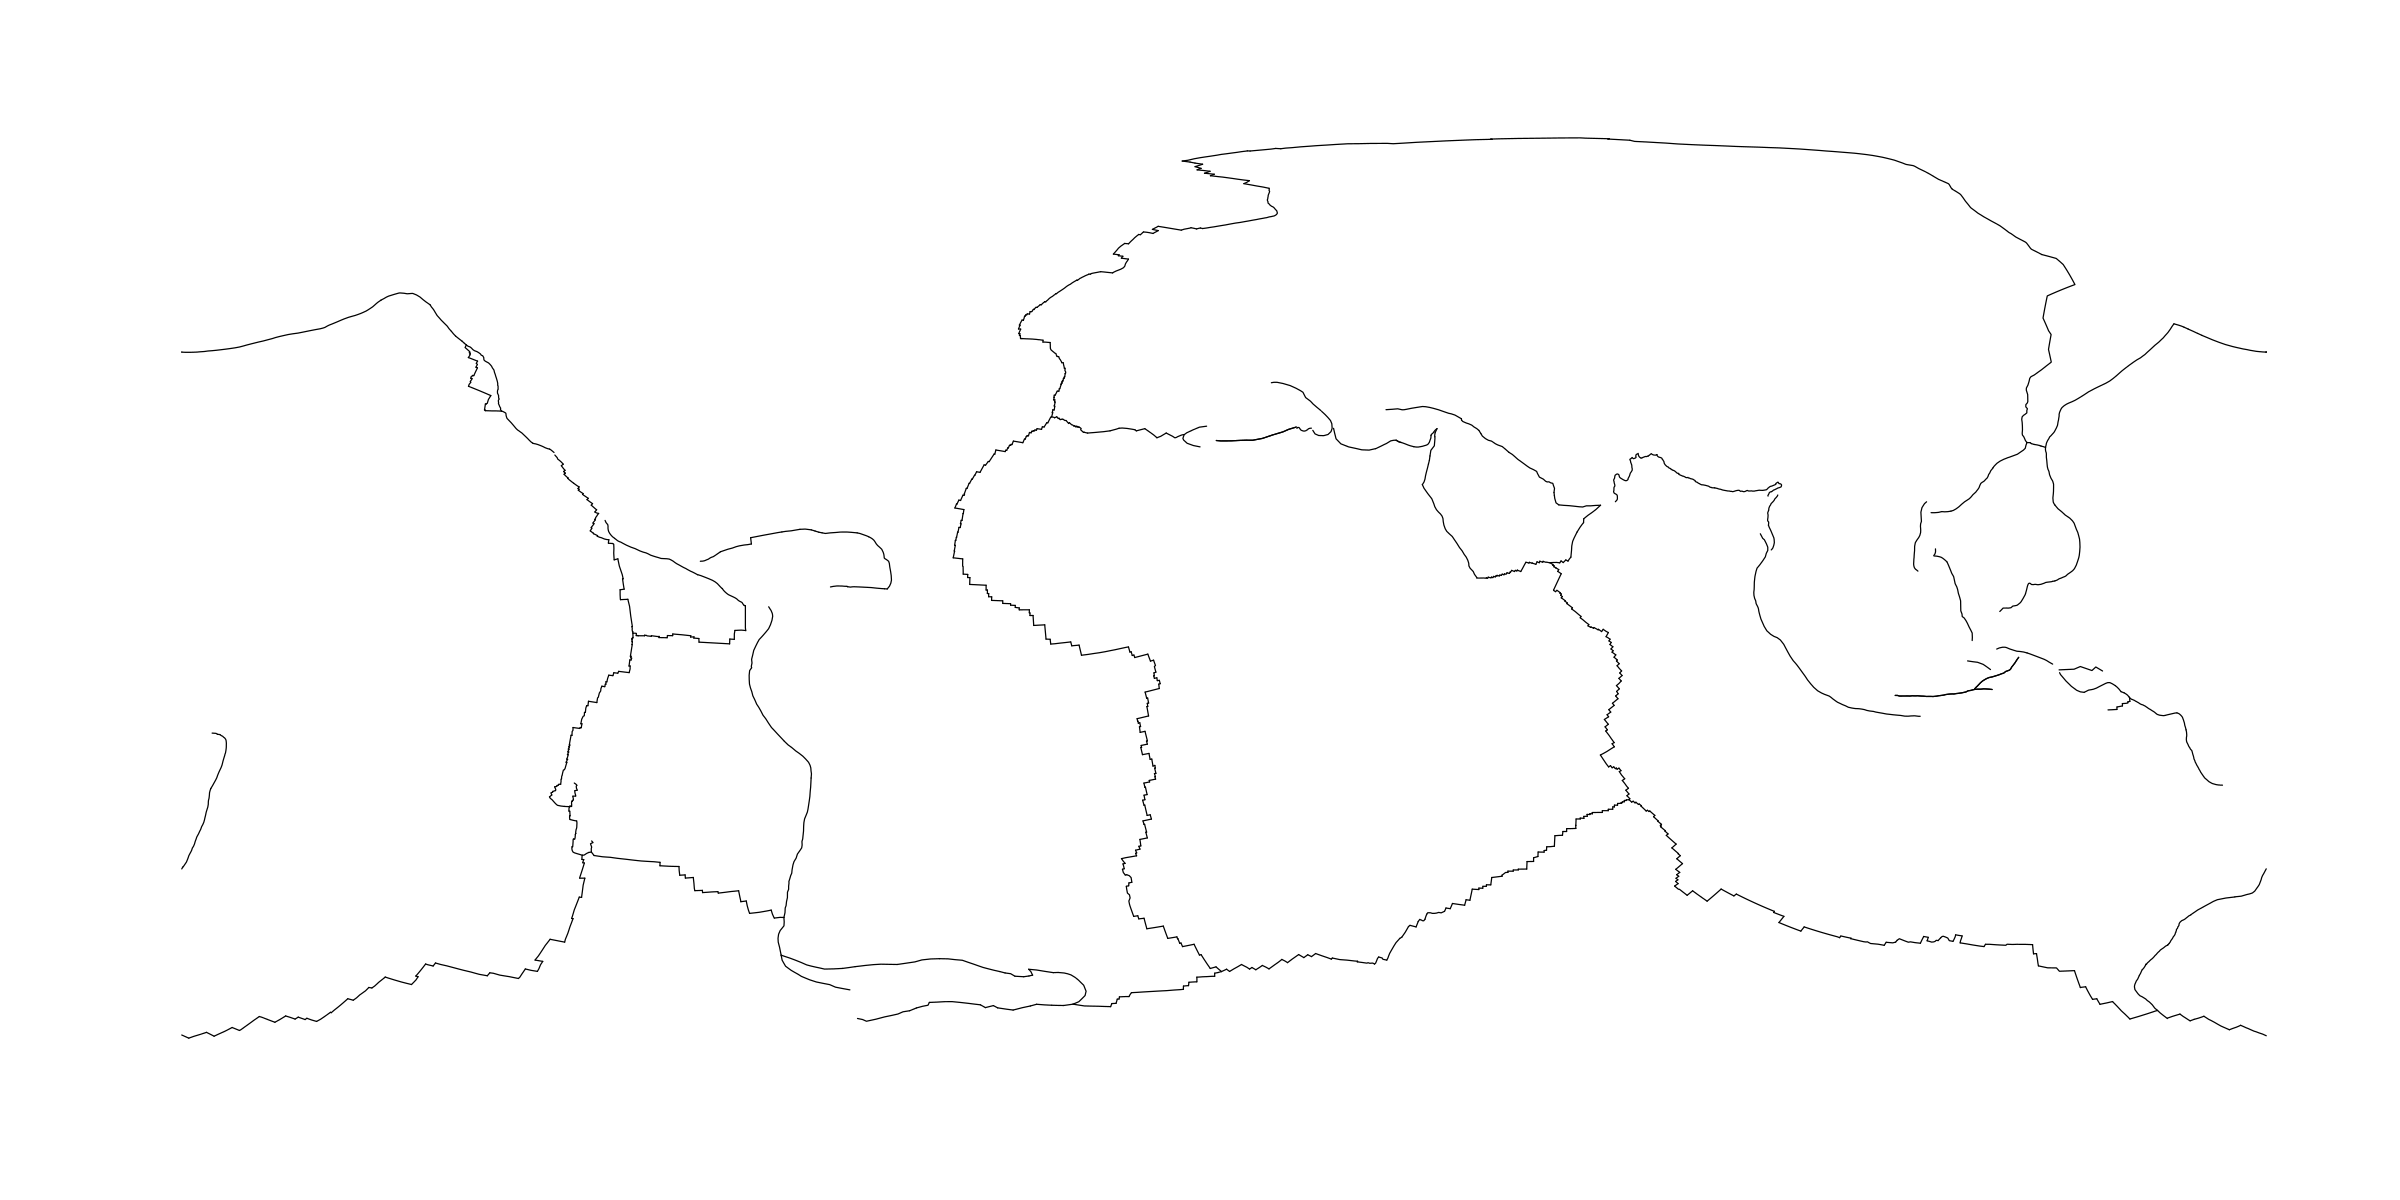

In [74]:
# Check that all is working well
print(plates)
plot(st_geometry(plates))  

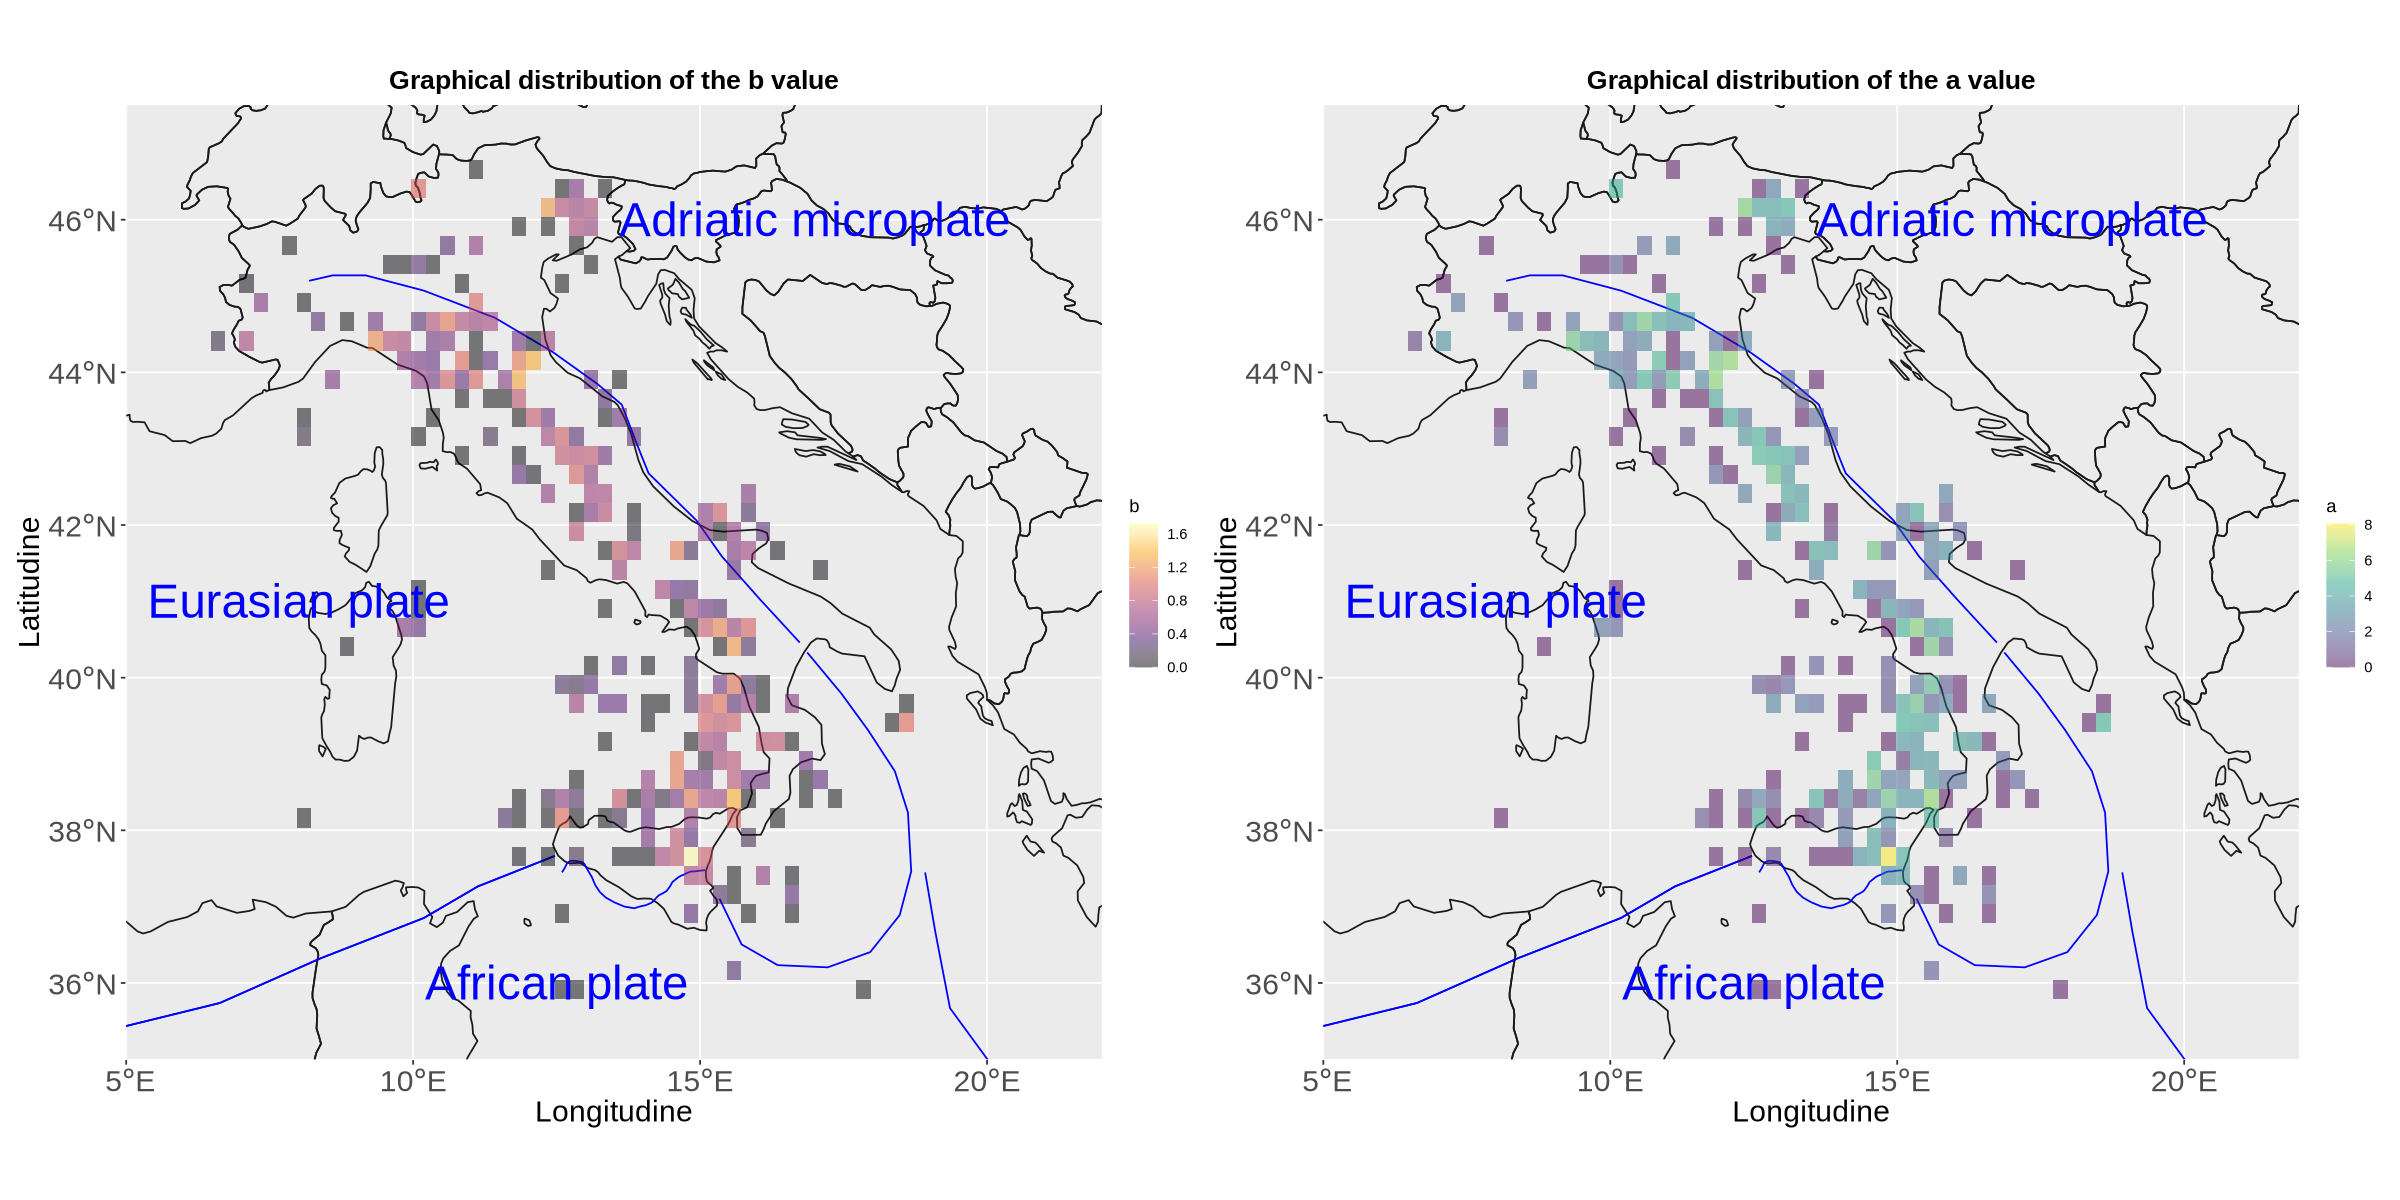

In [84]:
plates_names <- function() {
  annotate("text", x = c(8, 17, 12.5), y = c(41, 46, 36),
           label = c("Eurasian plate", "Adriatic microplate", "African plate"),
           size = 10, color = "blue")
}

# add add tectonic plate boundaries
a_plot_plates <- ggplot() +
  # borders
  borders("world", 
          regions = c(reg), 
          fill = "gray80", colour = "gray10", alpha = 0) +

  # placche tettoniche
  geom_sf(data = plates, color = "blue", size = 2) +

  # heatmap parametro b
  geom_tile(data = a_df, aes(x = lon, y = lat, fill = a_value), color = NA, na.rm = TRUE) +
  coord_sf(xlim = c(5, 22), ylim = c(35, 47.5), expand = FALSE) +
  scale_fill_viridis_c(option = "viridis", na.value = "transparent", alpha = 0.5) +
  labs(title = "Graphical distribution of the a value", x = "Longitudine", y = "Latitudine", fill = "a") +
  proj_theme()+
    plates_names()


b_plot_plates <- ggplot() +
  # borders
  borders("world", 
          regions = c(reg), 
          fill = "gray80", colour = "gray10", alpha = 0) +

  # placche tettoniche
  geom_sf(data = plates, color = "blue", size = 2) +

  # heatmap parametro b
  geom_tile(data = b_df, aes(x = lon, y = lat, fill = b_value), color = NA, na.rm = TRUE) +
  coord_sf(xlim = c(5, 22), ylim = c(35, 47.5), expand = FALSE) +
  scale_fill_viridis_c(option = "inferno", na.value = "transparent", alpha = 0.5) +
  labs(title = "Graphical distribution of the b value", x = "Longitudine", y = "Latitudine", fill = "b") +
  proj_theme()+
    plates_names()
b_plot_plates + a_plot_plates

ggsave("G_R_parameters_plates.png", plot = b_plot_plates + a_plot_plates, width = 20, height = 10, dpi = 300)

We can now construct a naive model based on the G-R law parameters found in the previous step. We assume that high-magnitude earthquakes are rare events, that they occur at a constant average number, and that they are independent events. Therefore, they follow a Poisson distribution. I then calculate, area by area, the probability of having $n$ events of magnitude greater than or equal to a threshold magnitude value in the next $k$ years.



In [76]:
# Threshold
M_threshold <- 5
years <- 10
n <- 1

# Probabilities matrices
P_strong <- matrix(NA, nrow = length(j), ncol = length(k))

for (lat_i in j){
  for (lon_i in k){
    a <- a_values[lat_i, lon_i]
    b <- b_values[lat_i, lon_i]
    if (!is.na(a) & !is.na(b) ){
      lambda <- 10^(a - b * M_threshold) * years/100    # a and b came from the fit of 100 years
      P_strong[lat_i, lon_i] <- 1 - ppois(n-1, lambda)
    }
  }
}

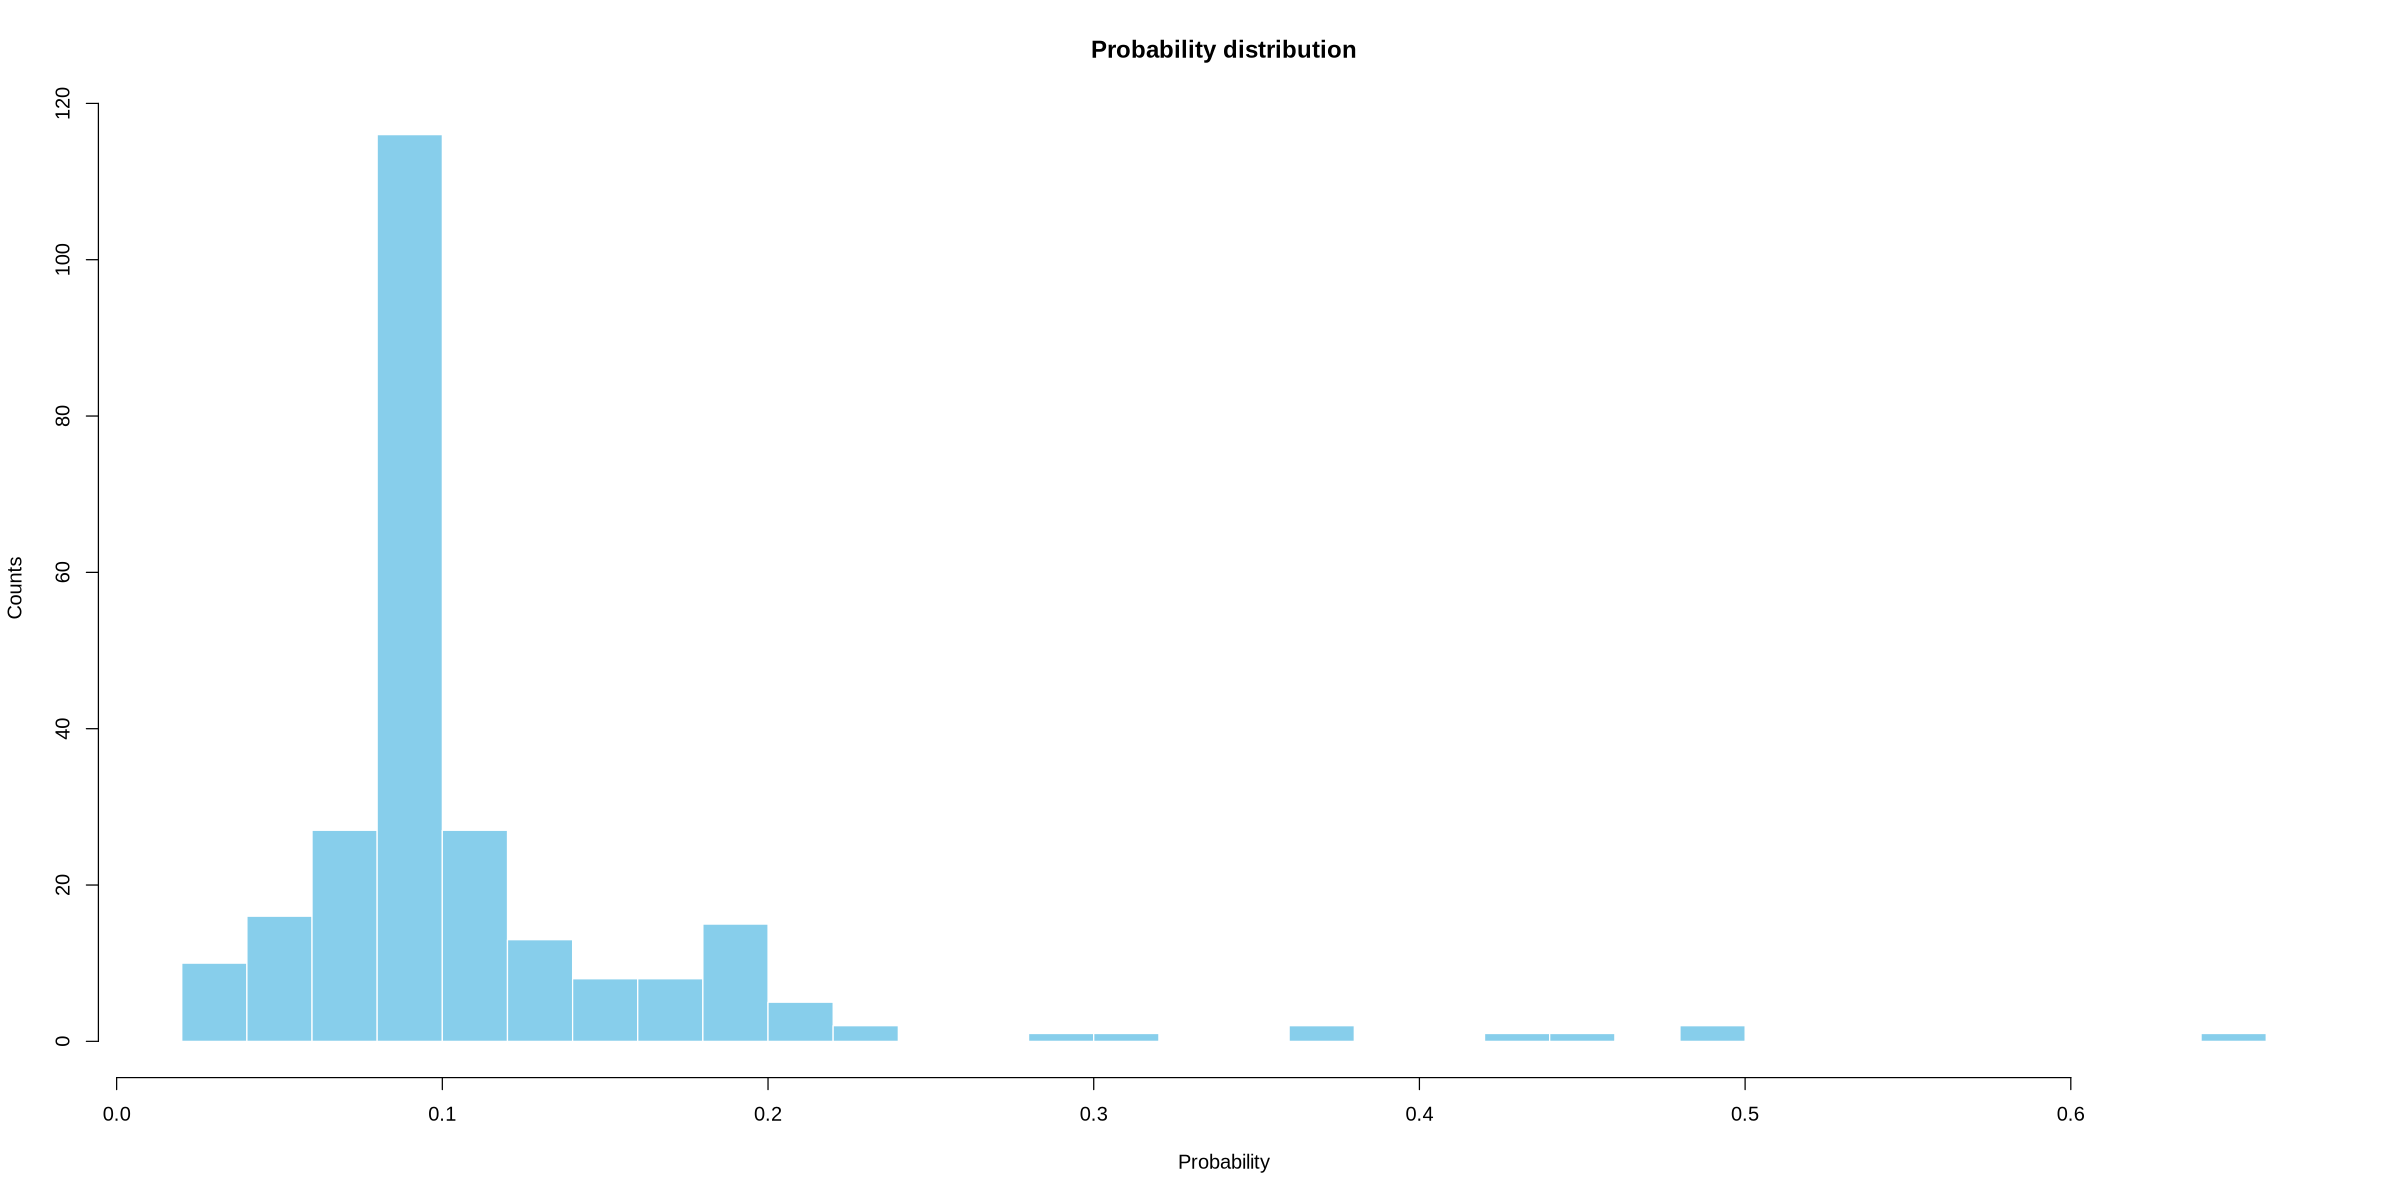

In [77]:
# Estrai tutti i valori non-zero e non-NA dalla matrice
prob_values <- P_strong[!is.na(P_strong) & P_strong != 0]

# Crea un istogramma della distribuzione dei valori
hist(prob_values, 
     breaks = 30,
     main = "Probability distribution", 
     xlab = "Probability", 
     ylab = "Counts", 
     col = "skyblue", 
     border = "white")


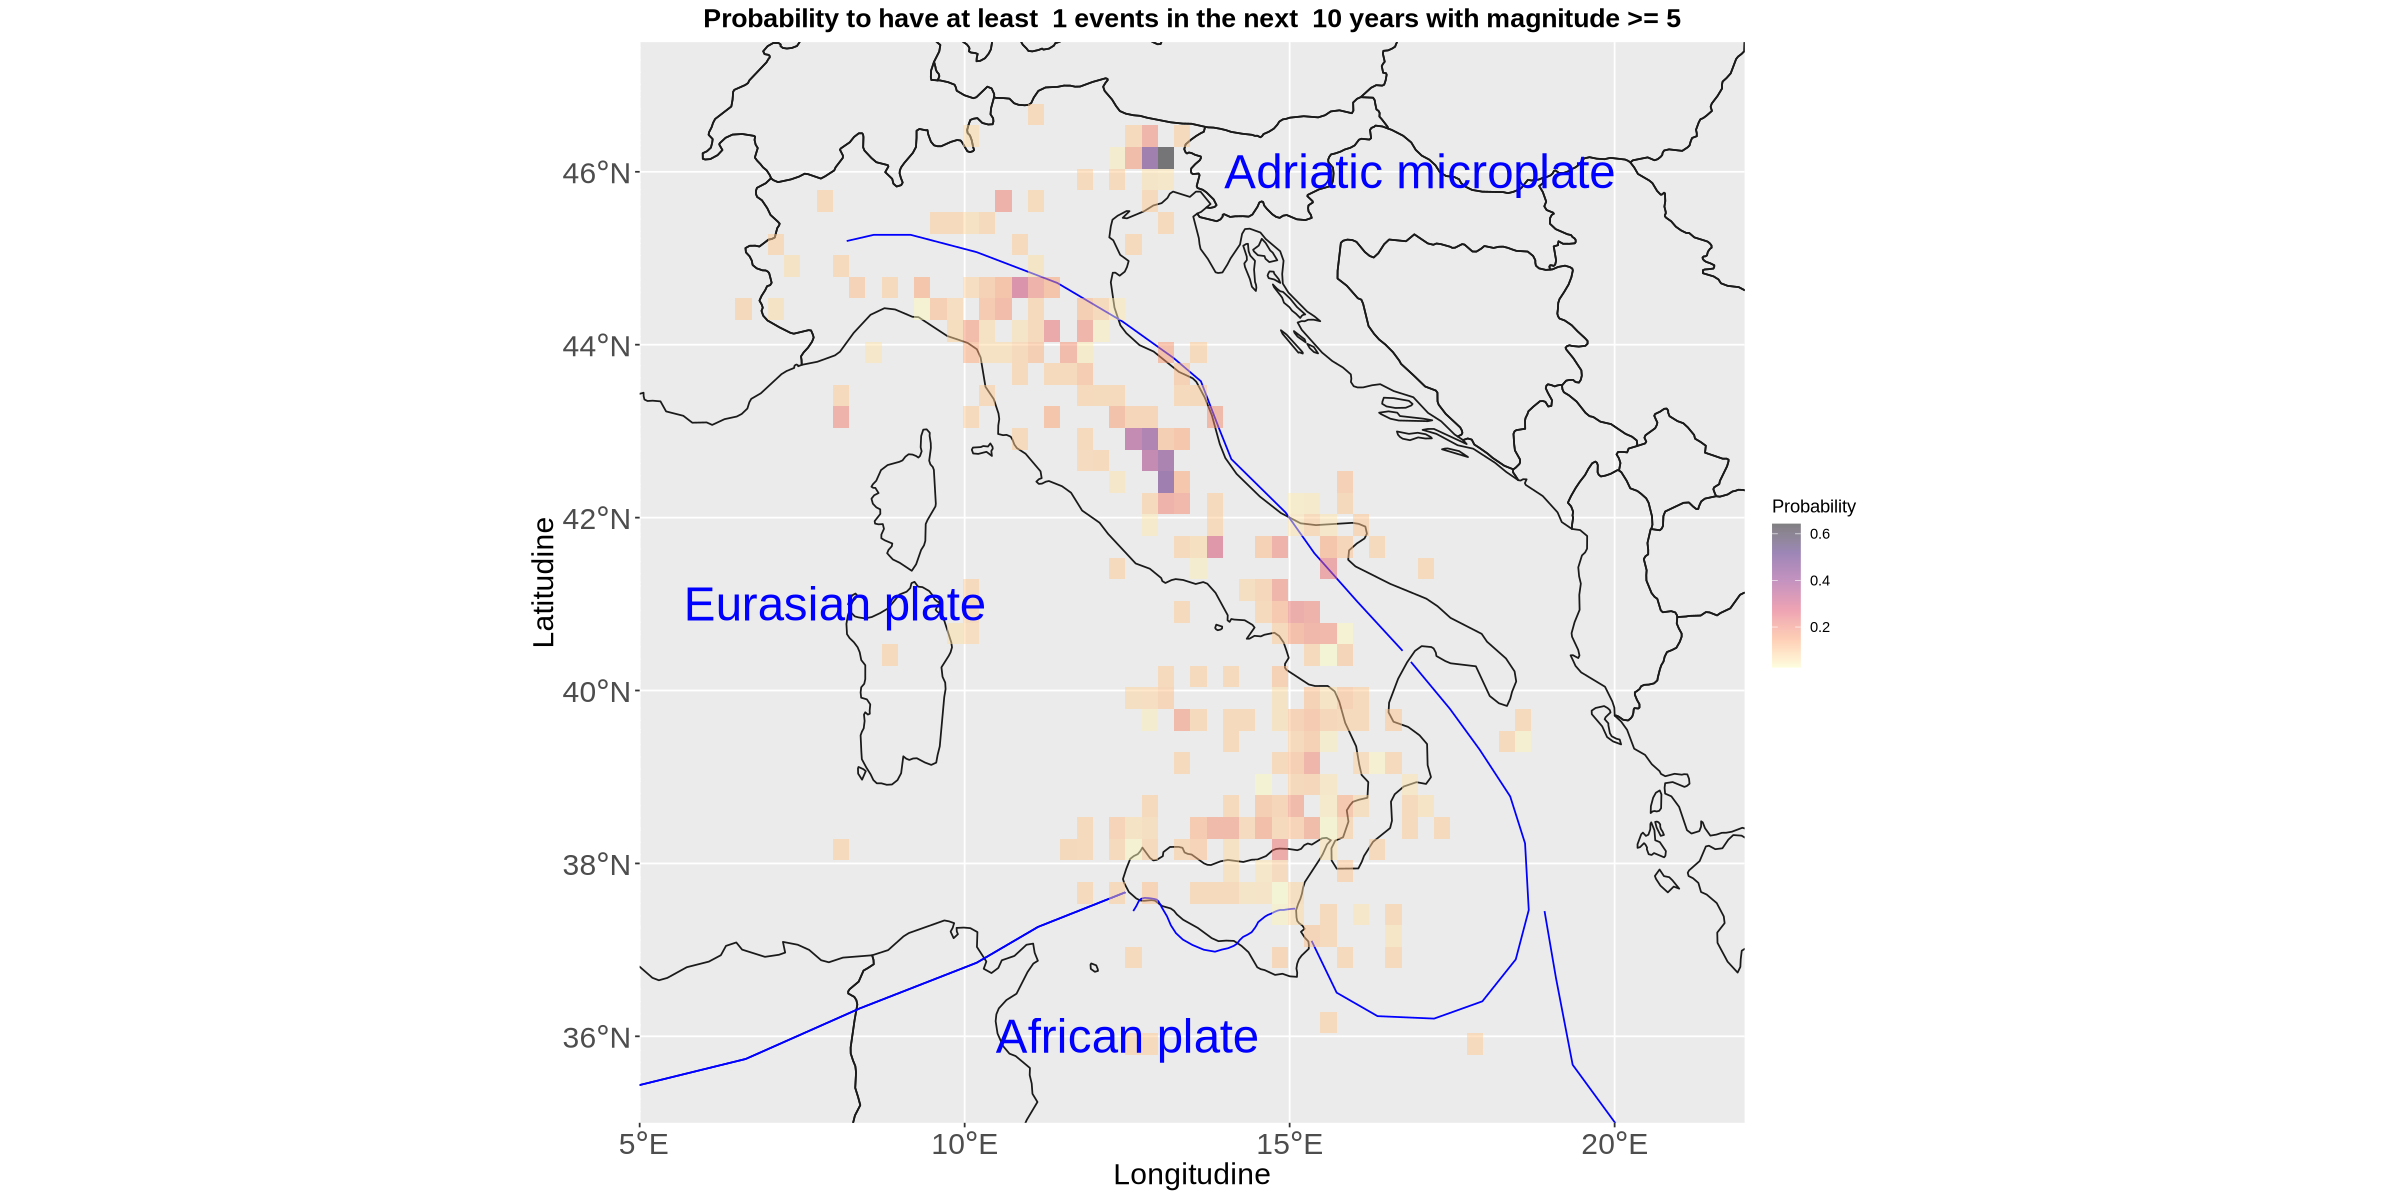

In [86]:
# Prepare the dataframe
P_df <- melt(P_strong)

colnames(P_df) <- c("lat_index", "lon_index", "prob")

P_df$lat <- lat_grid[P_df$lat_index]
P_df$lon <- lon_grid[P_df$lon_index]


prob_plot <- ggplot() +
  # borders
  borders("world", 
          regions = c(reg), 
          fill = "gray80", colour = "gray10", alpha = 0) +

  # tectonics plates
  geom_sf(data = plates, color = "blue", size = 2) +

  # probability heatmap 
  geom_tile(data = P_df, aes(x = lon, y = lat, fill = prob), color = NA, na.rm = TRUE) +
  coord_sf(xlim = c(5, 22), ylim = c(35, 47.5), expand = FALSE) +
  scale_fill_viridis_c(option = "magma", na.value = "transparent", alpha = 0.5, direction=-1) +
  labs(title = paste("Probability to have at least ", n, "events in the next ", years, "years", "with magnitude >=", M_threshold ), x = "Longitudine", y = "Latitudine", fill = "Probability") +
  proj_theme()+
    plates_names()

prob_plot

#ggsave("probability.png", plot = prob_plot, width = 10, height = 20, dpi = 300)

## Hierarchical cluster analysis

In [79]:
ev_coordinates <- df_cleaned %>%
  filter(mag > 5) %>% filter(grepl("Italy$", place)) %>%
  select(longitude, latitude)

# create the distances matrix
dist_matrix <- distm(ev_coordinates, fun = distHaversine)  # distances between the events

In [80]:
# Inspect the main characteristics
dim(dist_matrix)
any(is.na(dist_matrix))
class(dist_matrix)
str(dist_matrix)
class(dist_matrix)

[1] 201 201

[1] FALSE

[1] "matrix" "array"

 num [1:201, 1:201] 0 228460 656318 144368 612804 ...


[1] "matrix" "array"

In [111]:
# Perform the clustering
h_cluster <- hclust(as.dist(dist_matrix), method = "ward.D2") # we can use other methods instead ward.D2

# Cut the tree in k clusters
cluster <- cutree(h_cluster, k = 5)

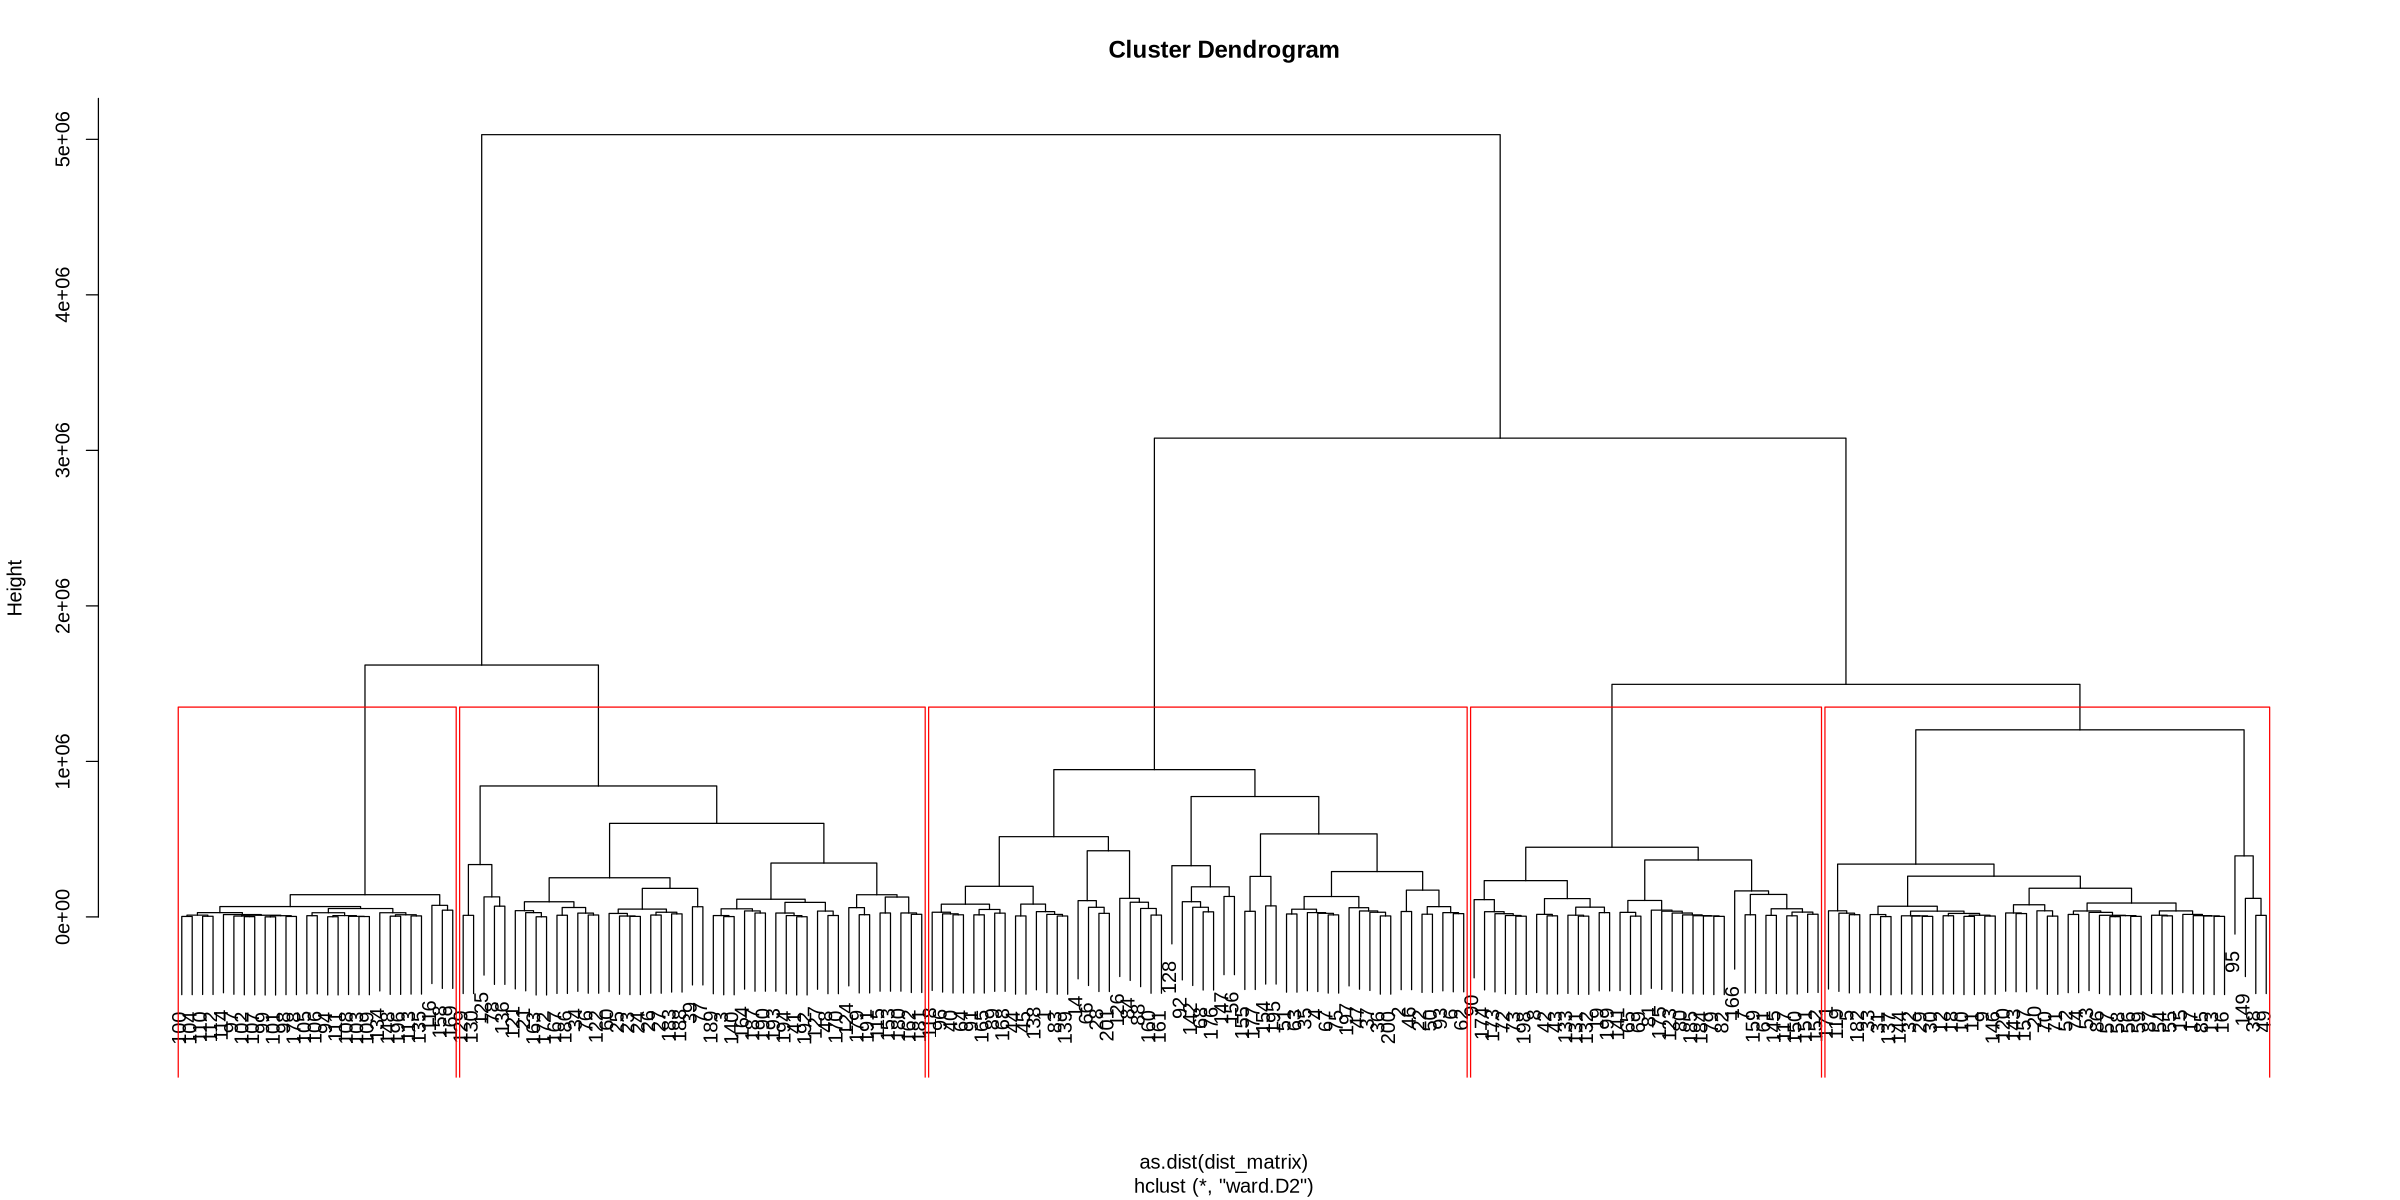

In [112]:
plot(h_cluster)
rect.hclust(h_cluster, k = 5, border = "red")  # Cut into 3 clusters

In [113]:
# Add the clusters to the data frame
ev_coordinates$cluster <- factor(cluster)  # better choice to add it as factor for color rappresentations

# Italy shape
italy_map <- map_data("world", region = "Italy")

# Plot
cluster_plot <- ggplot() +
  geom_polygon(data = italy_map, aes(x = long, y = lat, group = group),
               fill = "gray90", color = "black") +
  geom_point(data = ev_coordinates, aes(x = longitude, y = latitude, color = cluster),
             size = 2, alpha = 0.8) +
  coord_fixed(1.3) +
  labs(color = "Cluster", x = "Longitude", y = "Latitude")+
proj_theme()

ggsave("clustering_5.png", plot = cluster_plot, width = 10, height = 20, dpi = 300)